In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import json
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier
from modAL.uncertainty import uncertainty_sampling
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM
import spacy

In [2]:
negative_example_ids = []
negative_example_json = json.load(open("negative_examples_100_2.json"))
for example in negative_example_json:
    negative_example_ids.append((example["ap"], example["technique"]))

In [3]:
with open("w_dict.json", "r") as f:
    w_dict = json.load(f)
with open("ap_dict.json", "r") as f:
    ap_dict = json.load(f)
with open("technique_dict.json", "r") as f:
    technique_dict = json.load(f)
with open("tactic_dict.json", "r") as f:
    tactic_dict = json.load(f)
with open("cwe_names.json", "r") as f:
    cwe_names = json.load(f)
with open("ap_names.json", "r") as f:
    ap_names = json.load(f)
with open("technique_names.json", "r") as f:
    technique_names = json.load(f)
with open("tactic_names.json", "r") as f:
    tactic_names = json.load(f)
with open("ap_mitigation_descriptions.json", "r") as f:
    ap_mitigation_descriptions = json.load(f)
with open("cwe_mitigation_descriptions.json", "r") as f:
    cwe_mitigation_descriptions = json.load(f)
with open("tech_mitigation_names.json", "r") as f:
    tech_mitigation_names = json.load(f)
with open("tech_detection_names.json", "r") as f:
    tech_detection_names = json.load(f)
with open("ap_detection_descriptions.json", "r") as f:
    ap_detection_descriptions = json.load(f)
with open("cwe_detection_descriptions.json", "r") as f:
    cwe_detection_descriptions = json.load(f)

f = open("cwe_mitigation_ids_temp.json")
w_mitigation = json.load(f)

f = open("capec_mitigation_temp.json")
ap_mitigation = json.load(f)

f = open("technique_mitigation_temp.json")
technique_mitigation = json.load(f)

f = open("technique_detection_temp.json")
technique_detection = json.load(f)

f = open("capec_detection_temp.json")
ap_detection = json.load(f)

f = open("cwe_detection_temp.json")
w_detection = json.load(f)

In [4]:
positive_example_ids = []
for ap in ap_dict:
    for technique in ap_dict[ap]["techniques"]:
        positive_example_ids.append((ap, technique))

In [5]:
example_ids = positive_example_ids + negative_example_ids

In [6]:
encode = spacy.load("en_core_web_lg")

In [7]:
ap_name_vectorizer = CountVectorizer()
ap_name_vectorizer.fit(ap_names)

technique_name_vectorizer = CountVectorizer()
technique_name_vectorizer.fit(technique_names)

cwe_name_vectorizer = CountVectorizer()
cwe_name_vectorizer.fit(cwe_names)

tactic_name_vectorizer = CountVectorizer()
tactic_name_vectorizer.fit(tactic_names)

ap_mitigation_vectorizer = CountVectorizer()
cwe_mitigation_vectorizer = CountVectorizer()
tech_mitigation_vectorizer = CountVectorizer()

ap_mitigation_vectorizer.fit(ap_mitigation_descriptions)
cwe_mitigation_vectorizer.fit(cwe_mitigation_descriptions)
tech_mitigation_vectorizer.fit(tech_mitigation_names)

CountVectorizer()

In [8]:
device = "cpu"

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
pretrained_model = AutoModel.from_pretrained("bert-base-uncased").to(device)

model_path = "bert_base"
finetuned_model = AutoModelForMaskedLM.from_pretrained(model_path).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
def vector_encoding(
    encoding_type, text, vectorizer=None, bert_output_type=None, bert_finetuned=False
):
    if encoding_type == "None":
        return text
    elif encoding_type == "BoW":
        return vectorizer_transform(text, vectorizer)
    elif encoding_type == "spaCy":
        return spaCy_vector(text)
    elif encoding_type == "BERT":
        if bert_finetuned:
            model = finetuned_model
        else:
            model = pretrained_model

        if bert_output_type == "pooler_output":
            return get_pooler_output(model, text)
        elif bert_output_type == "hidden_state":
            return get_hidden_state(model, text)


def vectorizer_transform(input_to_BoW, vectorizer):
    return vectorizer.transform([input_to_BoW])[0].toarray().flatten()


def spaCy_vector(text):
    return encode(text).vector


def get_pooler_output(model, text):
    inputs = tokenizer(text.lower(), truncation=True, return_tensors="pt").to(device)
    outputs = model(**inputs)
    pooled_output = outputs.pooler_output
    return pooled_output.detach().cpu().numpy().flatten()


def get_hidden_state(model, text):
    inputs = tokenizer(text.lower(), truncation=True, return_tensors="pt").to(device)
    outputs = model(**inputs, output_hidden_states=True)
    hidden_states = outputs.hidden_states
    return hidden_states[-1][:, 0, :].detach().cpu().numpy().flatten()


def append_data(
    encoding_type,
    data_combo,
    ap,
    technique,
    bert_output_type=None,
    bert_finetuned=False,
):
    output = []
    vectorizer = CountVectorizer()
    if data_combo == "A0":
        vectorizer.fit(ap_names + technique_names)

    elif data_combo == "A1":
        vectorizer.fit(ap_names + technique_names + cwe_names + tactic_names)

    elif data_combo == "A1 + MI":
        vectorizer.fit(
            ap_names
            + technique_names
            + cwe_names
            + tactic_names
            + cwe_mitigation_descriptions
            + ap_mitigation_descriptions
            + tech_mitigation_names
        )

    elif data_combo == "A1 + D":
        vectorizer.fit(
            ap_names
            + technique_names
            + cwe_names
            + tactic_names
            + cwe_detection_descriptions
            + ap_detection_descriptions
            + tech_detection_names
        )

    elif data_combo == "A1 + MI + D":
        vectorizer.fit(
            ap_names
            + technique_names
            + cwe_names
            + tactic_names
            + cwe_mitigation_descriptions
            + ap_mitigation_descriptions
            + tech_mitigation_names
            + cwe_detection_descriptions
            + ap_detection_descriptions
            + tech_detection_names
        )

    output.append(ap_dict[ap]["name"])
    output.append(technique_dict[technique]["name"])

    if "A1" in data_combo:
        for cwe in ap_dict[ap]["cwes"]:
            output.append(w_dict[cwe]["name"])

        for tac in technique_dict[technique]["tactics"]:
            output.append(tactic_dict[tac]["name"])

    if data_combo in ["A1 + MI", "A1 + MI + D"]:
        for cwe in ap_dict[ap]["cwes"]:
            for mitigation in w_dict[cwe]["mitigations"]:
                for cwe_mit in w_mitigation:
                    if mitigation == cwe_mit["_id"]:
                        output.append(cwe_mit["metadata"]["Description"])

        for mitigation in ap_dict[ap]["mitigations"]:
            for ap_mit in ap_mitigation:
                if mitigation == ap_mit["_id"]:
                    output.append(ap_mit["metadata"])

        for mitigation in technique_dict[technique]["mitigations"]:
            for tech_mit in technique_mitigation:
                if mitigation == tech_mit["_id"]:
                    output.append(tech_mit["name"])

    if data_combo in ["A1 + D", "A1 + MI + D"]:
        for cwe in ap_dict[ap]["cwes"]:
            for detection in w_dict[cwe]["detections"]:
                for cwe_det in w_detection:
                    if detection == cwe_det["_id"]:
                        output.append(cwe_det["metadata"]["Description"])

        for detection in ap_dict[ap]["detections"]:
            for ap_det in ap_detection:
                if detection == ap_det["_id"]:
                    output.append(ap_det["metadata"])

        for detection in technique_dict[technique]["detections"]:
            for tech_det in technique_mitigation:
                if detection == tech_det["_id"]:
                    output.append(tech_det["metadata"])

    output = " ".join(output)
    return vector_encoding(
        encoding_type, output, vectorizer, bert_output_type, bert_finetuned
    )


def handle_data(
    encoding_type,
    data_combo,
    ap,
    technique,
    bert_output_type=None,
    bert_finetuned=False,
):
    example = []
    example.append(
        vector_encoding(
            encoding_type,
            ap_dict[ap]["name"],
            ap_name_vectorizer,
            bert_output_type,
            bert_finetuned,
        )
    )
    example.append(
        vector_encoding(
            encoding_type,
            technique_dict[technique]["name"],
            technique_name_vectorizer,
            bert_output_type,
            bert_finetuned,
        )
    )

    if "A1" in data_combo:
        tactics = []
        for tac in technique_dict[technique]["tactics"]:
            tactics.append(tactic_dict[tac]["name"])
        tactics = " ".join(tactics)
        example.append(
            vector_encoding(
                encoding_type,
                tactics,
                tactic_name_vectorizer,
                bert_output_type,
                bert_finetuned,
            )
        )

        cwes = []
        for cwe in ap_dict[ap]["cwes"]:
            cwes.append(w_dict[cwe]["name"])
        cwes = " ".join(cwes)
        example.append(
            vector_encoding(
                encoding_type,
                cwes,
                cwe_name_vectorizer,
                bert_output_type,
                bert_finetuned,
            )
        )

    if data_combo in ["A1 + MI", "A1 + MI + D"]:
        cwe_mitigations = []
        for cwe in ap_dict[ap]["cwes"]:
            for mitigation in w_dict[cwe]["mitigations"]:
                for cwe_mit in w_mitigation:
                    if mitigation == cwe_mit["_id"]:
                        cwe_mitigations.append(cwe_mit["metadata"]["Description"])
        cwe_mitigations = " ".join(cwe_mitigations)
        example.append(
            vector_encoding(
                encoding_type,
                cwe_mitigations,
                cwe_mitigation_vectorizer,
                bert_output_type,
                bert_finetuned,
            )
        )

        capec_mitigations = []
        for mitigation in ap_dict[ap]["mitigations"]:
            for ap_mit in ap_mitigation:
                if mitigation == ap_mit["_id"]:
                    capec_mitigations.append(ap_mit["metadata"])
        capec_mitigations = " ".join(capec_mitigations)
        example.append(
            vector_encoding(
                encoding_type,
                capec_mitigations,
                ap_mitigation_vectorizer,
                bert_output_type,
                bert_finetuned,
            )
        )

        tech_mitigations = []
        for mitigation in technique_dict[technique]["mitigations"]:
            for tech_mit in technique_mitigation:
                if mitigation == tech_mit["_id"]:
                    tech_mitigations.append(tech_mit["name"])
        tech_mitigations = " ".join(tech_mitigations)
        example.append(
            vector_encoding(
                encoding_type,
                tech_mitigations,
                tech_mitigation_vectorizer,
                bert_output_type,
                bert_finetuned,
            )
        )

    if data_combo in ["A1 + D", "A1 + MI + D"]:
        cwe_detections = []
        for cwe in ap_dict[ap]["cwes"]:
            for detection in w_dict[cwe]["detections"]:
                for cwe_det in w_detection:
                    if detection == cwe_det["_id"]:
                        cwe_detections.append(cwe_det["metadata"]["Description"])

        cwe_detections = " ".join(cwe_detections)
        example.append(
            vector_encoding(
                encoding_type,
                cwe_detections,
                cwe_detection_vectorizer,
                bert_output_type,
                bert_finetuned,
            )
        )

        capec_detections = []
        for detection in ap_dict[ap]["detections"]:
            for ap_det in ap_detection:
                if detection == ap_det["_id"]:
                    capec_detections.append(ap_det["metadata"])
        capec_detections = " ".join(capec_detections)
        example.append(
            vector_encoding(
                encoding_type,
                capec_detections,
                ap_detection_vectorizer,
                bert_output_type,
                bert_finetuned,
            )
        )

        tech_detections = []
        for detection in technique_dict[technique]["detections"]:
            for tech_det in technique_detection:
                if detection == tech_det["_id"]:
                    tech_detections.append(tech_det["name"])
        tech_detections = " ".join(tech_detections)
        example.append(
            vector_encoding(
                encoding_type,
                tech_detections,
                tech_detection_vectorizer,
                bert_output_type,
                bert_finetuned,
            )
        )

    return np.hstack(example)


def encode_data(
    encoding_type,
    data_combo,
    ap,
    technique,
    bert_output_type=None,
    bert_finetuned=False,
):
    example = []
    example.append(
        vector_encoding(
            encoding_type,
            ap_dict[ap]["name"],
            ap_name_vectorizer,
            bert_output_type,
            bert_finetuned,
        )
    )
    example.append(
        vector_encoding(
            encoding_type,
            technique_dict[technique]["name"],
            technique_name_vectorizer,
            bert_output_type,
            bert_finetuned,
        )
    )

    if "A1" in data_combo:
        for cwe in ap_dict[ap]["cwes"]:
            example.append(
                vector_encoding(
                    encoding_type,
                    w_dict[cwe]["name"],
                    cwe_name_vectorizer,
                    bert_output_type,
                    bert_finetuned,
                )
            )

        for tac in technique_dict[technique]["tactics"]:
            example.append(
                vector_encoding(
                    encoding_type,
                    tactic_dict[tac]["name"],
                    tactic_name_vectorizer,
                    bert_output_type,
                    bert_finetuned,
                )
            )

    if data_combo in ["A1 + MI", "A1 + MI + D"]:
        for cwe in ap_dict[ap]["cwes"]:
            for mitigation in w_dict[cwe]["mitigations"]:
                for cwe_mit in w_mitigation:
                    if mitigation == cwe_mit["_id"]:
                        example.append(
                            vector_encoding(
                                encoding_type,
                                cwe_mit["metadata"]["Description"],
                                cwe_mitigation_vectorizer,
                                bert_output_type,
                                bert_finetuned,
                            )
                        )

        for mitigation in ap_dict[ap]["mitigations"]:
            for ap_mit in ap_mitigation:
                if mitigation == ap_mit["_id"]:
                    example.append(
                        vector_encoding(
                            encoding_type,
                            ap_mit["metadata"],
                            ap_mitigation_vectorizer,
                            bert_output_type,
                            bert_finetuned,
                        )
                    )

        for mitigation in technique_dict[technique]["mitigations"]:
            for tech_mit in technique_mitigation:
                if mitigation == tech_mit["_id"]:
                    example.append(
                        vector_encoding(
                            encoding_type,
                            tech_mit["name"],
                            tech_mitigation_vectorizer,
                            bert_output_type,
                            bert_finetuned,
                        )
                    )

    if data_combo in ["A1 + D", "A1 + MI + D"]:
        for cwe in ap_dict[ap]["cwes"]:
            for detection in w_dict[cwe]["detections"]:
                for cwe_det in w_detection:
                    if detection == cwe_det["_id"]:
                        example.append(
                            vector_encoding(
                                encoding_type,
                                cwe_det["metadata"]["Description"],
                                cwe_detection_vectorizer,
                                bert_output_type,
                                bert_finetuned,
                            )
                        )

        for detection in ap_dict[ap]["detections"]:
            for ap_det in ap_detection:
                if detection == ap_det["_id"]:
                    example.append(
                        vector_encoding(
                            encoding_type,
                            ap_det["metadata"],
                            ap_detection_vectorizer,
                            bert_output_type,
                            bert_finetuned,
                        )
                    )

        for detection in technique_dict[technique]["detections"]:
            for tech_det in technique_detection:
                if detection == tech_det["_id"]:
                    example.append(
                        vector_encoding(
                            encoding_type,
                            tech_det["name"],
                            tech_detection_vectorizer,
                            bert_output_type,
                            bert_finetuned,
                        )
                    )

    return np.hstack(example)

In [10]:
labels = []
examples = []
for i, (ap, technique) in enumerate(example_ids):
    example = []
    # examples.append(handle_data("BoW", "A1", ap, technique))
    examples.append(handle_data("spaCy", "A1 + MI", ap, technique))
    # examples.append(handle_data("BERT", "A1", ap, technique, bert_output_type="hidden_state", bert_finetuned=True))

    if i < len(example_ids) / 2:
        labels.append(1)
    else:
        labels.append(0)

In [11]:
# Pool-based sampling based on https://modal-python.readthedocs.io/en/latest/content/examples/pool-based_sampling.html
def active_learning(learner, X_train, y_train, X_test, y_test, initial_idx, n_initial):
    X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(
        y_train, initial_idx, axis=0
    )

    initial_train_score = learner.score(X_train, y_train)
    initial_test_score = learner.score(X_test, y_test)

    num_queries = len(X_train) - n_initial
    train_accs = [initial_train_score]
    test_accs = [initial_test_score]

    for i in range(num_queries):
        query_index, query_instance = learner.query(X_pool)

        X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(
            1,
        )

        learner.teach(X=X, y=y)

        X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(
            y_pool, query_index
        )

        train_accs.append(learner.score(X_train, y_train))
        test_accs.append(learner.score(X_test, y_test))

    return train_accs, test_accs

In [12]:
# Initial training set setup based on https://modal-python.readthedocs.io/en/latest/content/examples/interactive_labeling.html
# Random sampling based on "Replacing parts with your own solutions" in https://github.com/modAL-python/modAL
ratios = [0.25, 0.5, 0.75]
results = {}
for ratio in ratios:
    results[str(ratio)] = {
        "train": {"uncertainty": [], "random": []},
        "test": {"uncertainty": [], "random": []},
    }
    for seed in range(100):
        X_train, X_test, y_train, y_test = train_test_split(
            np.array(examples), np.array(labels), test_size=0.3, random_state=seed
        )
        n_initial = round(ratio * len(X_train))
        np.random.seed(seed)
        initial_idx = np.random.choice(
            range(len(X_train)), size=n_initial, replace=False
        )
        X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]

        uncertainty_learner = ActiveLearner(
            estimator=RandomForestClassifier(random_state=seed),
            X_training=X_initial,
            y_training=y_initial,
            query_strategy=uncertainty_sampling,
        )

        train_accs, test_accs = active_learning(
            uncertainty_learner,
            X_train,
            y_train,
            X_test,
            y_test,
            initial_idx,
            n_initial,
        )
        results[str(ratio)]["train"]["uncertainty"].append(sum(train_accs))
        results[str(ratio)]["test"]["uncertainty"].append(sum(test_accs))

        def random_sampling(classifier, X):
            index = np.random.choice(range(len(X)))
            return index, X[index]

        random_learner = ActiveLearner(
            estimator=RandomForestClassifier(random_state=seed),
            X_training=X_initial,
            y_training=y_initial,
            query_strategy=random_sampling,
        )

        train_accs, test_accs = active_learning(
            random_learner, X_train, y_train, X_test, y_test, initial_idx, n_initial
        )
        results[str(ratio)]["train"]["random"].append(sum(train_accs))
        results[str(ratio)]["test"]["random"].append(sum(test_accs))

In [13]:
with open("active_learning_100_trials_spaCy_A1+MI.json", "w") as f:
    json.dump(results, f)

In [14]:
with open("active_learning_100_trials_BoW.json", "r") as f:
    results = json.load(f)

In [15]:
for ratio in results:
    print("Ratio: ", ratio)
    for dataset in results[ratio]:
        print("Dataset: ", dataset)
        w, p = wilcoxon(
            results[ratio][dataset]["uncertainty"], results[ratio][dataset]["random"]
        )
        print("Uncertainty mean ", np.mean(results[ratio][dataset]["uncertainty"]))
        print("Random mean ", np.mean(results[ratio][dataset]["random"]))
        print("p value ", p)

Ratio:  0.25
Dataset:  train
Uncertainty mean  109.93815950920239
Random mean  106.61680981595089
p value  9.318997235593406e-18
Dataset:  test
Uncertainty mean  84.46957746478873
Random mean  81.83676056338027
p value  1.490247569483896e-07
Ratio:  0.5
Dataset:  train
Uncertainty mean  76.93417177914111
Random mean  75.43325153374231
p value  5.112258973385463e-18
Dataset:  test
Uncertainty mean  57.738873239436614
Random mean  56.18985915492957
p value  1.830039780176053e-12
Ratio:  0.75
Dataset:  train
Uncertainty mean  40.7979754601227
Random mean  40.40687116564417
p value  1.3324605170425474e-17
Dataset:  test
Uncertainty mean  29.683802816901412
Random mean  29.43619718309859
p value  0.0016644939117470405


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array(examples), np.array(labels), random_state=0
)
n_initial = round(0.5 * len(X_train))
np.random.seed(0)
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]

uncertainty_learner = ActiveLearner(
    estimator=RandomForestClassifier(random_state=0),
    X_training=X_initial,
    y_training=y_initial,
    query_strategy=uncertainty_sampling,
)


def random_sampling(classifier, X):
    index = np.random.choice(range(len(X)))
    return index, X[index]


train_uncertainty_accs, test_uncertainty_accs = active_learning(
    uncertainty_learner, X_train, y_train, X_test, y_test, initial_idx, n_initial
)

random_learner = ActiveLearner(
    estimator=RandomForestClassifier(random_state=0),
    X_training=X_initial,
    y_training=y_initial,
    query_strategy=random_sampling,
)

train_random_accs, test_random_accs = active_learning(
    random_learner, X_train, y_train, X_test, y_test, initial_idx, n_initial
)

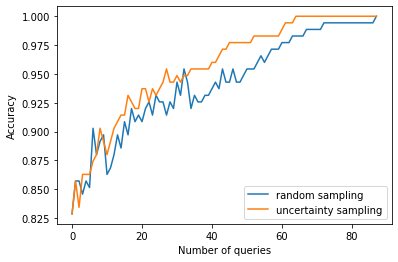

In [17]:
plt.plot(train_random_accs, label="random sampling")
plt.plot(train_uncertainty_accs, label="uncertainty sampling")
plt.xlabel("Number of queries")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")